## <u>**Tanh activation function Training**<u>



### Simple CNN Model 1
MODEL: Simple CNN
ACTIVATION FUNCTION: Tanh
OPTIMIZER: SGD

### Simple CNN Model 2
MODEL: Simple CNN
ACTIVATION FUNCTION: Tanh
OPTIMIZER: Adam

In [13]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [14]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [15]:
# Preparing and downloading the CIFAR-10 dataset
data_path = './data'

if not os.path.exists(data_path):
    trainSet = torchvision.datasets.CIFAR10(root=data_path, train=True,
                                            download=True, transform=transform)
    testSet = torchvision.datasets.CIFAR10(root=data_path, train=False,
                                           download=True, transform=transform)
else:
    trainSet = torchvision.datasets.CIFAR10(root=data_path, train=True,
                                            download=False, transform=transform)
    testSet = torchvision.datasets.CIFAR10(root=data_path, train=False,
                                           download=False, transform=transform)

In [16]:

trainSet = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testSet = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=64, shuffle=True, num_workers=2)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
#Classes for Image classification
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [18]:
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [19]:
# ACTIVATION FUNCTION: Leaky ReLU

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.tanh = nn.Tanh()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.tanh(self.conv1(x)))
        x = self.pool(self.tanh(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

net = SimpleCNN()

# Create two instances of the model
net_sgd = SimpleCNN().to(device)
net_adam = SimpleCNN().to(device)

In [20]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define both optimizers
SGDoptimizer = optim.SGD(net_sgd.parameters(), lr=0.0001)
Adamoptimizer = optim.Adam(net_adam.parameters(), lr=0.001)

In [21]:
# Initialize TensorBoard writers for visualization
writer_sgd = SummaryWriter('runs/SGD_run')
writer_adam = SummaryWriter('runs/Adam_run')

In [22]:
# Training function
def train_model(net, optimizer, writer, tag, epochs=10):
    net.train()
    for epoch in range(epochs):
        running_loss = 0.0
        progress_bar = tqdm(enumerate(trainLoader, 0),
                            total=len(trainLoader),
                            desc=f'{tag} Epoch {epoch + 1}/{epochs}',
                            leave=True,
                            ncols=100)

        for i, data in progress_bar:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 2000 == 1999:
                avg_loss = running_loss / 2000
                writer.add_scalar(f'Loss/{tag}', avg_loss, epoch * len(trainLoader) + i)
                running_loss = 0.0

            progress_bar.set_postfix(loss=loss.item())
    print(f'Finished Training with {tag}')

    
#Evaluation function

def evaluate_model(net, testloader, writer, tag):
    net.eval()
    correct = 0
    total = 0
    progress_bar = tqdm(testloader, desc=f'Evaluating {tag}', leave=True, ncols=100)

    with torch.no_grad():
        for data in progress_bar:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            acc = 100 * correct / total
            progress_bar.set_postfix(acc=f'{acc:.2f}%')

    final_acc = 100 * correct / total
    print(f'Final Accuracy with {tag} on 10000 test images: {final_acc:.2f}%')
    writer.add_scalar(f'Accuracy/{tag}', final_acc)

In [23]:
# Train both models
train_model(net_sgd, SGDoptimizer, writer_sgd, 'SGD')
train_model(net_adam, Adamoptimizer, writer_adam, 'Adam')

SGD Epoch 10/10: 100%|████████████████████████████████| 782/782 [00:07<00:00, 100.71it/s, loss=2.27]


Finished Training with SGD


Adam Epoch 10/10: 100%|███████████████████████████████| 782/782 [00:07<00:00, 105.40it/s, loss=1.47]

Finished Training with Adam


In [24]:
# Evaluate both models
evaluate_model(net_sgd, testLoader, writer_sgd, 'SGD')
evaluate_model(net_adam, testLoader, writer_adam, 'Adam')

Evaluating SGD: 100%|█████████████████████████████████| 157/157 [00:08<00:00, 18.50it/s, acc=21.60%]


Final Accuracy with SGD on 10000 test images: 21.60%


Evaluating Adam: 100%|████████████████████████████████| 157/157 [00:08<00:00, 18.95it/s, acc=66.35%]

Final Accuracy with Adam on 10000 test images: 66.35%


In [25]:
# Close writers
writer_sgd.close()
writer_adam.close()

Visit http://localhost:6006/ while the cell below is running

In [26]:
# Visualize tensorBoard
!tensorboard --logdir=./runs


^C


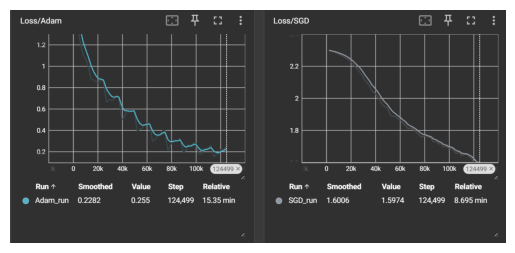

In [27]:
from PIL import Image
import matplotlib.pyplot as plt

# Relative path to the image
image_path = os.path.join('LTU', 'Advance-deep-learning-assignments','Practical-0', 'images', 'Task0.1_Tanh_TensorBoard.png')

# Open and display the image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off') 
plt.show()